# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


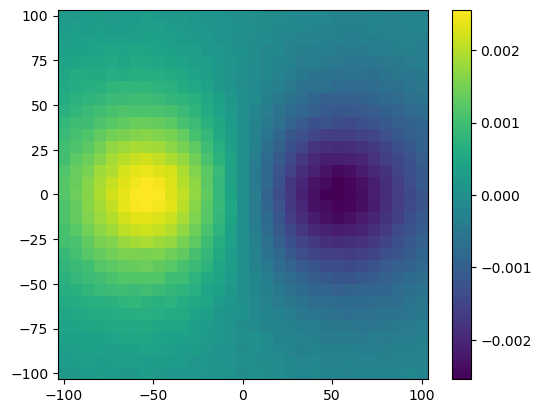

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7fc4a34d25d0>,)

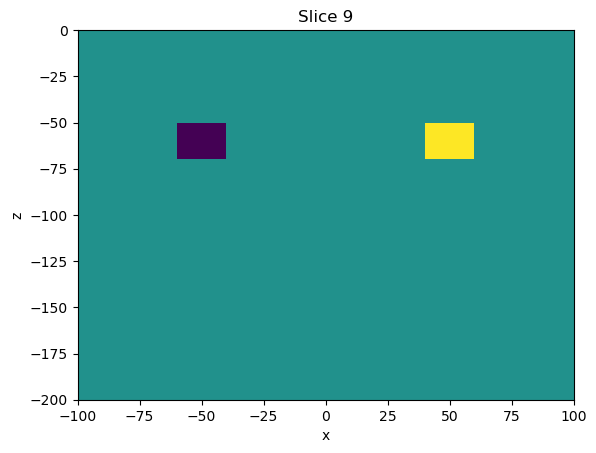

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

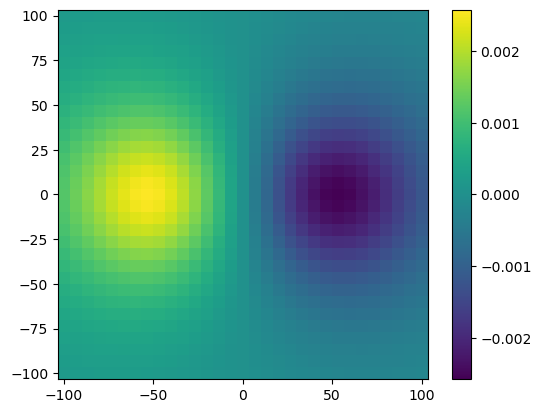

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
depth_weights = depth_weighting(mesh, 0) ** 2
sparse_smallness = ii.SparseSmallness(mesh=mesh, norm=1, cell_weights=depth_weights)

In [17]:
beta_0 = 1e5
regularization = beta_0 * sparse_smallness
phi = data_misfit + regularization
phi

φd(m) + 1.00e+05 φs(p=1)(m)

In [18]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Stopping criteria
chi_target = ii.ChiTarget(data_misfit, chi_target=1.0)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Preconditioner
preconditioner = ii.JacobiPreconditioner(phi)
minimizer_kwargs = {"preconditioner": preconditioner}

# Inversion
l2_inversion = ii.Inversion(
    phi,
    initial_model,
    ii.conjugate_gradient,
    directives=[beta_cooler],
    stopping_criteria=chi_target,
    cache_models=True,
    minimizer_kwargs=minimizer_kwargs,
)

In [19]:
model_l2 = l2_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [20]:
l2_inversion.stopping_criteria.info(model_l2)

[x] ChiTarget
├── Condition: chi < chi_target
├── chi        = 9.86e-01
└── chi_target = 1.00e+00

(<matplotlib.collections.QuadMesh at 0x7fc4a0eed950>,)

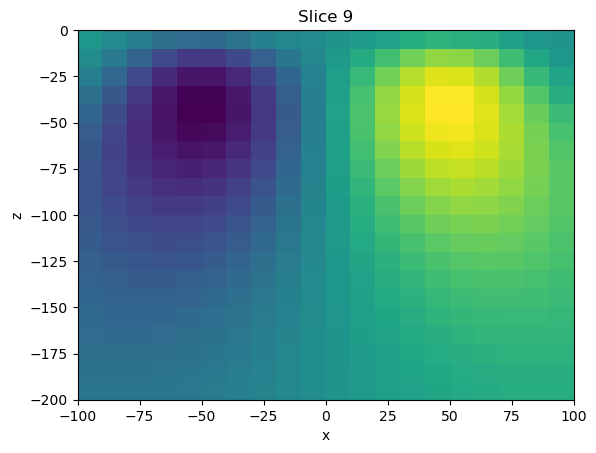

In [21]:
mesh.plot_slice(model_l2, normal="Y", slice_loc=0)

In [22]:
# Activate IRLS in smallness
# * Assign model to sparse smallness as previous model
# * Define epsilon: maximum abs value of the inverted model after the l2 inversion
sparse_smallness.activate_irls(model_l2)

# Define stopping criteria
smallness_not_changing = ii.ObjectiveChanged(sparse_smallness, rtol=1e-3)

sparse_inversion = ii.Inversion(
    phi,
    model_l2,
    ii.conjugate_gradient,
    directives=[],  # leave empty directives now, will handle manually
    stopping_criteria=smallness_not_changing,
    cache_models=True,
    max_iterations=80,
    minimizer_kwargs=minimizer_kwargs,
)

# Add columns to log
sparse_inversion.log.add_column(
    "irls threshold", lambda _, __: sparse_smallness.threshold
)

dmisfit_changed = ii.ObjectiveChanged(data_misfit)
dmisfit_changed.previous = data_misfit(model_l2)
sparse_inversion.log.add_column(
    "|phi_d - phi_d*| / |phi_d*|", lambda _, model: dmisfit_changed.ratio(model)
)
sparse_inversion.log.add_column(
    "|phi_m - phi_m*| / |phi_m*|", lambda _, model: smallness_not_changing.ratio(model)
)

In [23]:
# Define cooling rate for IRLS threshold (epsilon)
threshold_cooling_rate = 1.25

# Define a stopping criteria for the data misfit.
# Compare it always with the data misfit obtained with the model from l2 inversion.
dmisfit_below_threshold = ii.ObjectiveChanged(data_misfit, rtol=1e-1)
dmisfit_l2 = data_misfit(model_l2)
dmisfit_below_threshold.previous = dmisfit_l2

with sparse_inversion.log.live() as live:
    for model in sparse_inversion:
        if not dmisfit_below_threshold(model):
            # Cool beta if the data misfit is quite different from the l2 one
            phi_d = data_misfit(model)
            # Adjust the cooling factor (following current implementation of UpdateIRLS)
            if phi_d > dmisfit_l2:
                beta_cooler.cooling_factor = 1 / np.mean([0.75, dmisfit_l2 / phi_d])
            else:
                beta_cooler.cooling_factor = 1 / np.mean([2.0, dmisfit_l2 / phi_d])
            beta_cooler(model, sparse_inversion.counter)

        else:
            # Cool the irls threshold (epsilon)
            sparse_smallness.threshold /= threshold_cooling_rate
            # Assign current model as previous one to sparse
            sparse_smallness.model_previous = model
        live.refresh()

Output()

In [24]:
log = sparse_inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,irls threshold,|phi_d - phi_d*| / |phi_d*|,|phi_m - phi_m*| / |phi_m*|
iter,,,,,,,,,
0,50000.000000,947.830377,61.183028,3.059151e+06,3.060099e+06,0.986296,3.223121e-03,0.000000,NaN
1,50000.000000,565451.442397,7.721640,3.860820e+05,9.515335e+05,588.399004,3.223121e-03,595.574510,0.873794
2,18791.905914,236816.661897,18.373206,3.452676e+05,5.820842e+05,246.427328,3.223121e-03,248.851311,1.379443
3,7084.570896,79063.005370,31.603265,2.238956e+05,3.029586e+05,82.271598,3.223121e-03,82.414720,0.720073
4,2699.180038,21497.123645,44.096373,1.190240e+05,1.405212e+05,22.369536,3.223121e-03,21.680349,0.395311
5,1071.697331,5528.523849,52.869615,5.666023e+04,6.218875e+04,5.752886,3.223121e-03,4.832820,0.198956
6,493.754357,2021.055443,57.427542,2.835510e+04,3.037615e+04,2.103075,3.223121e-03,1.132297,0.086211
7,300.937829,1269.414147,59.332064,1.785526e+04,1.912468e+04,1.320930,3.223121e-03,0.339284,0.033164
8,225.201945,1042.329650,60.197659,1.355663e+04,1.459896e+04,1.084630,3.223121e-03,0.099701,0.014589


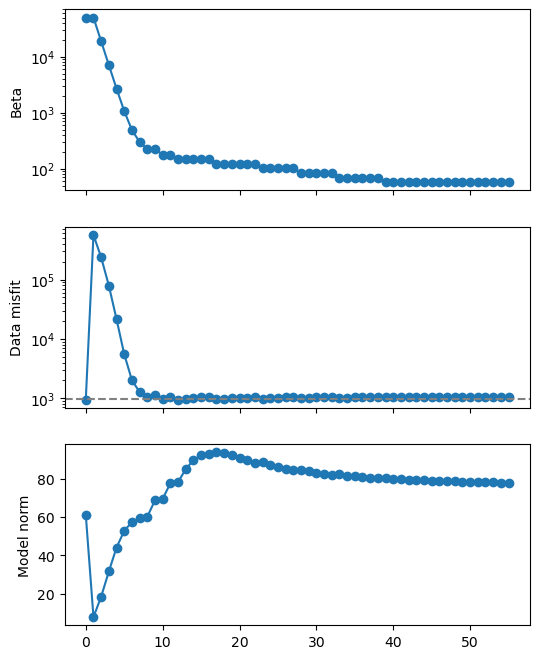

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")
axes[0].set_yscale("log")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

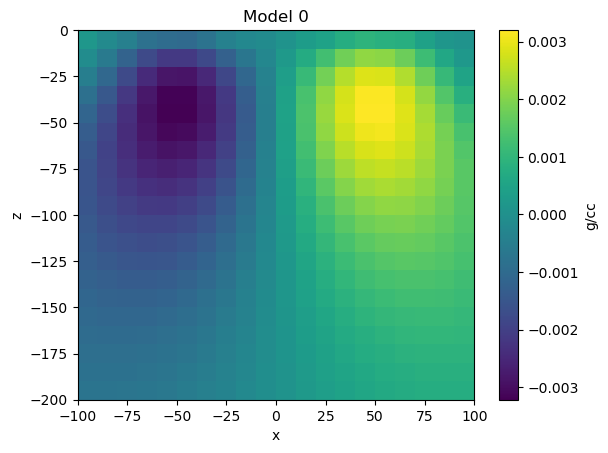

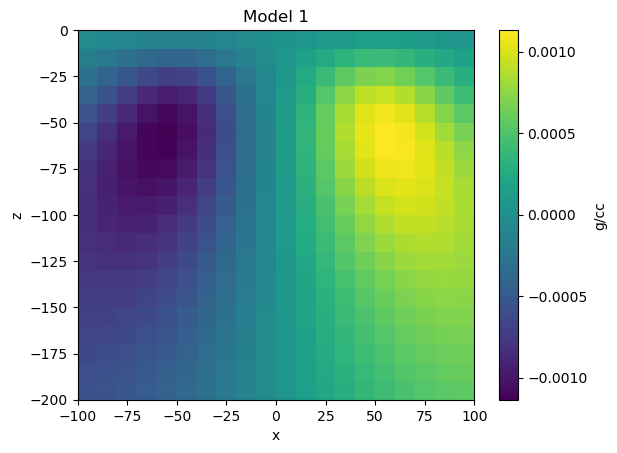

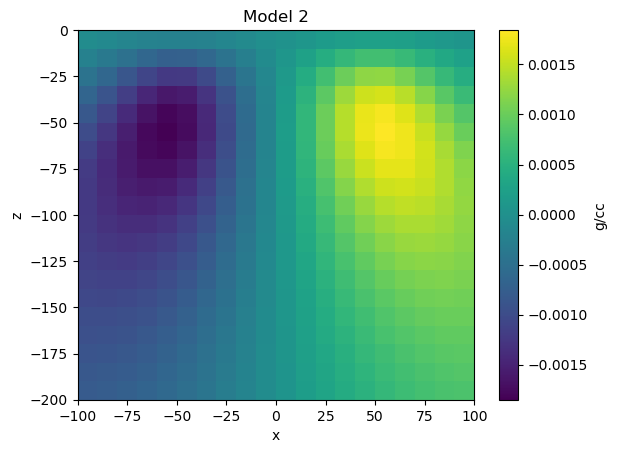

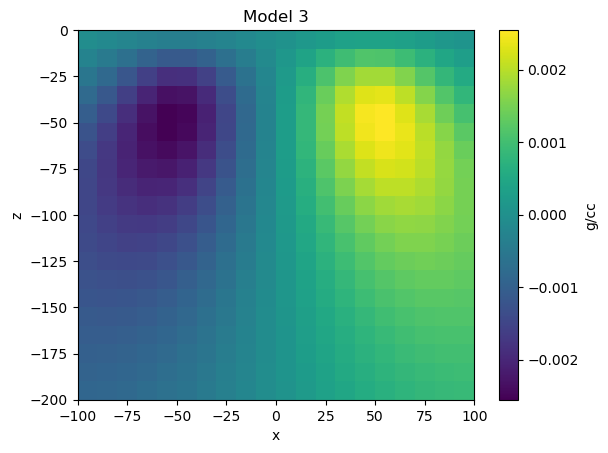

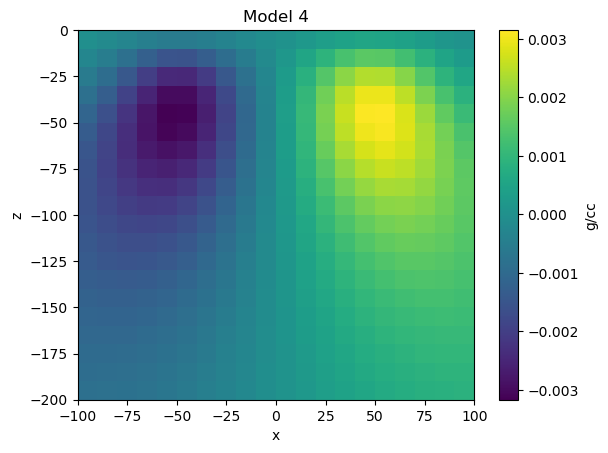

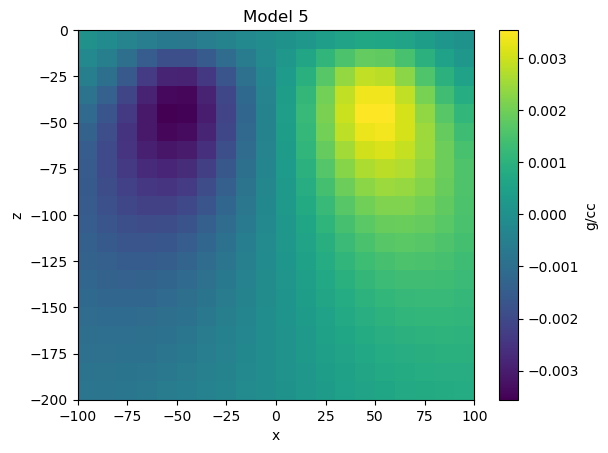

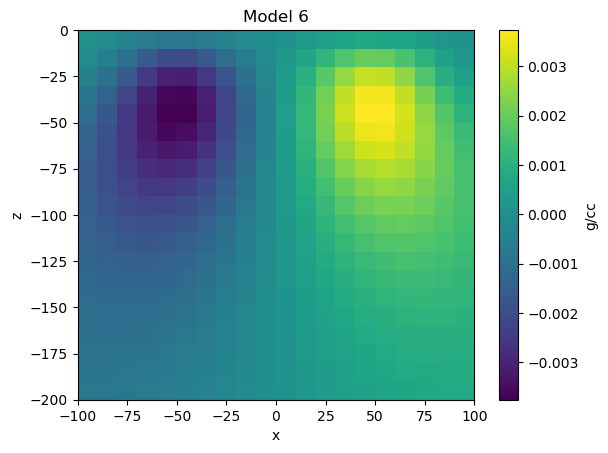

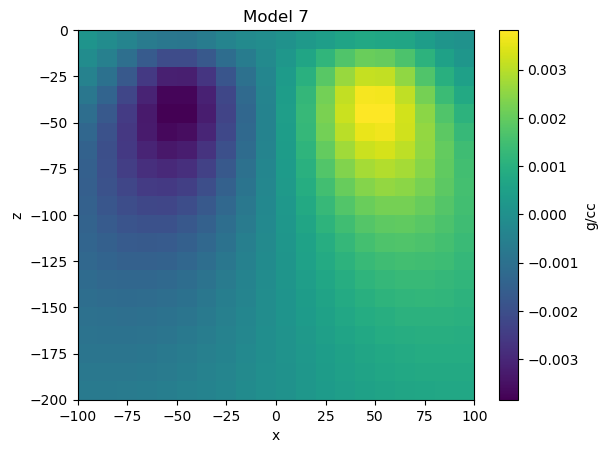

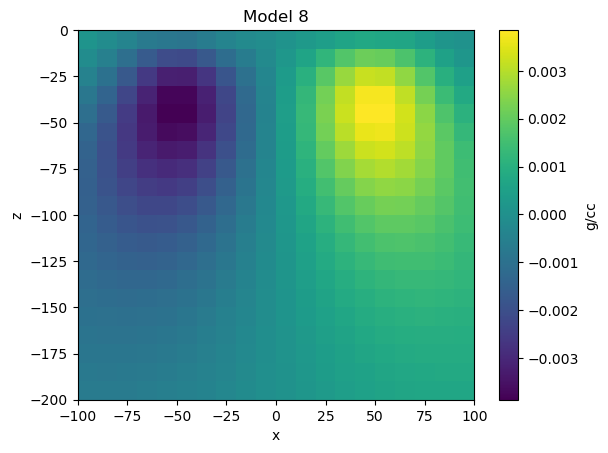

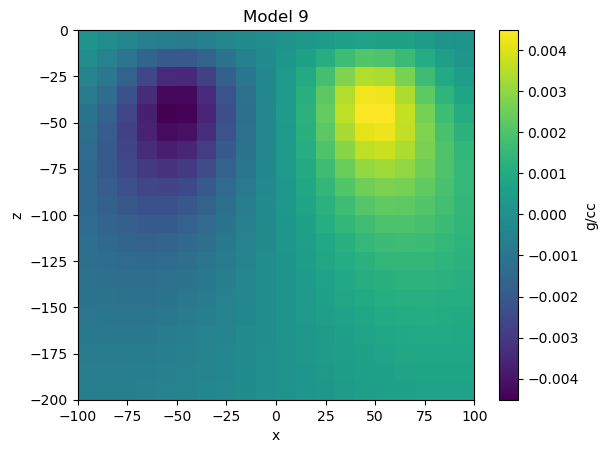

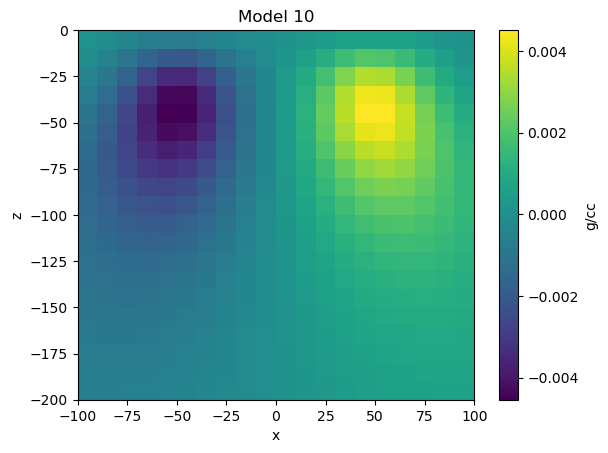

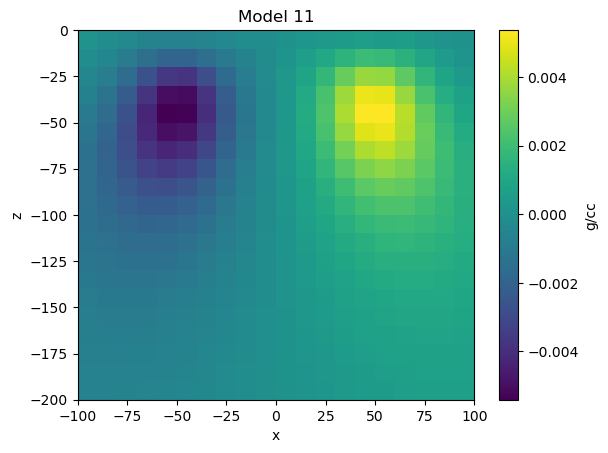

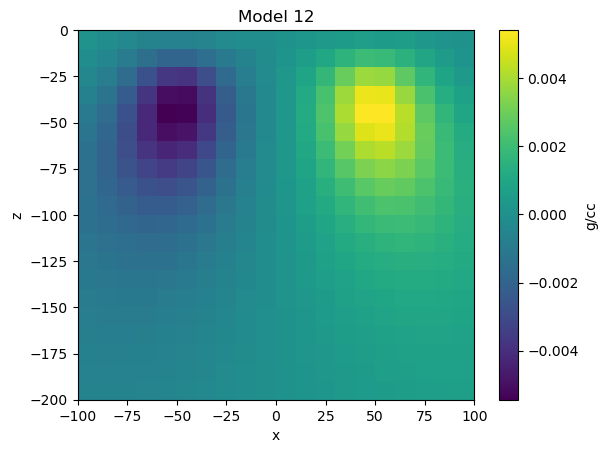

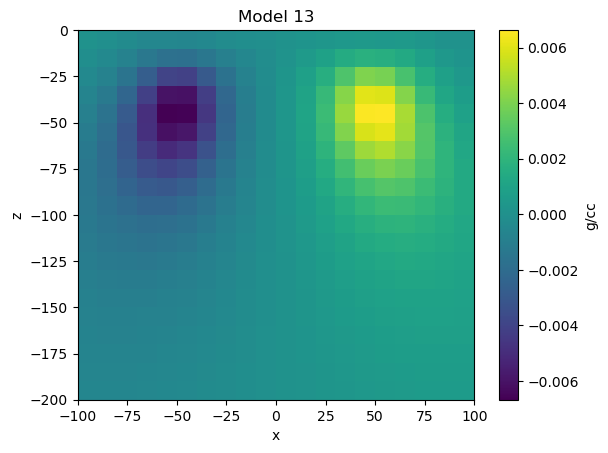

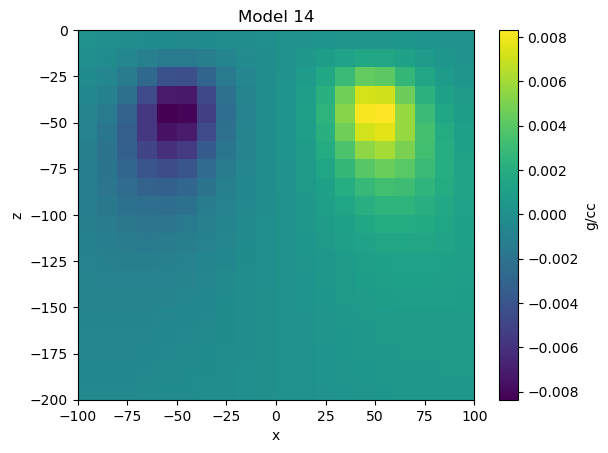

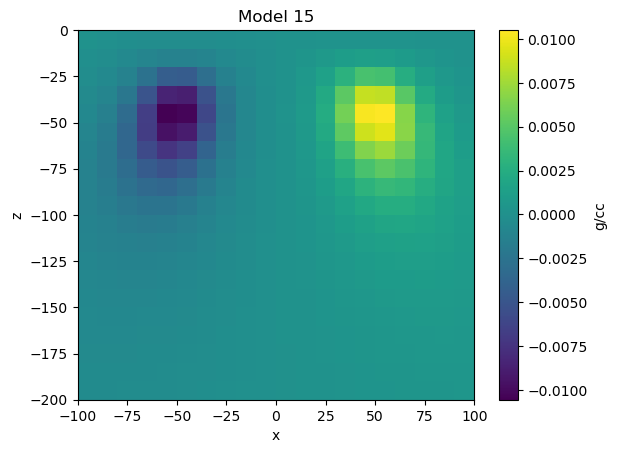

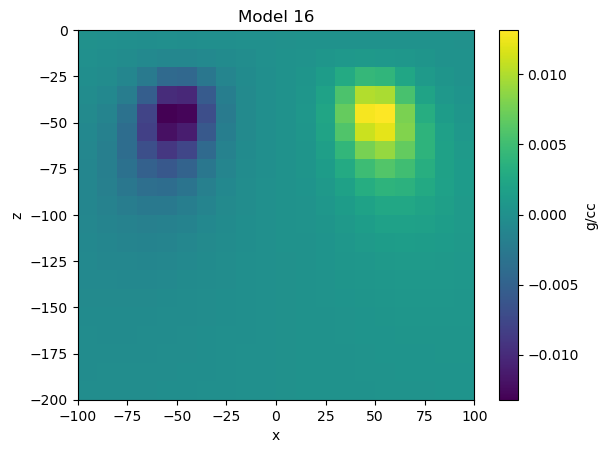

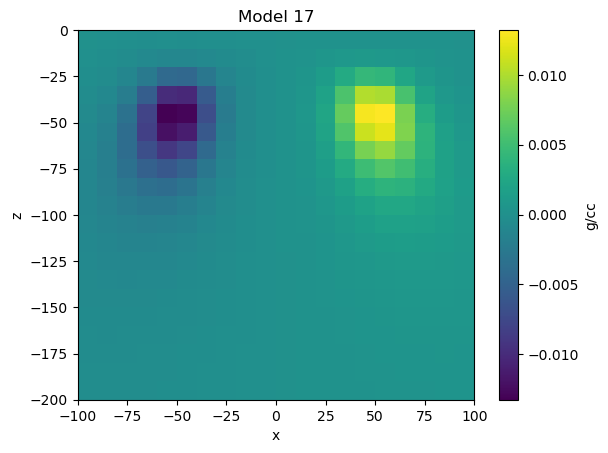

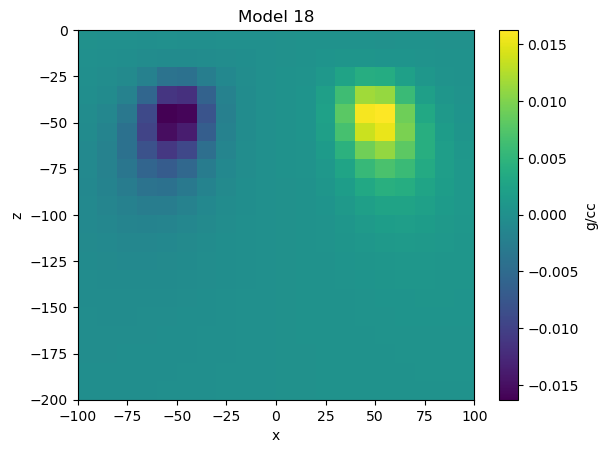

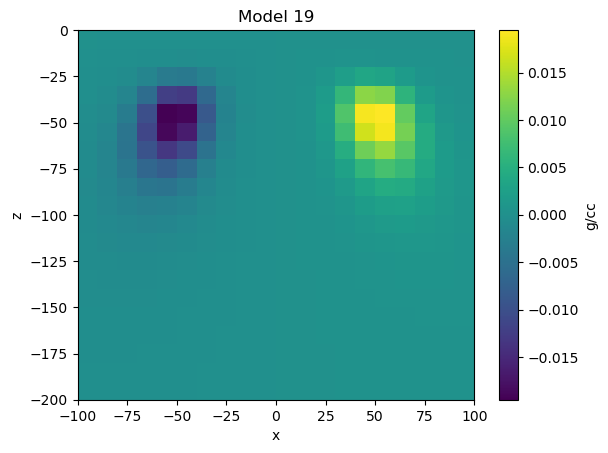

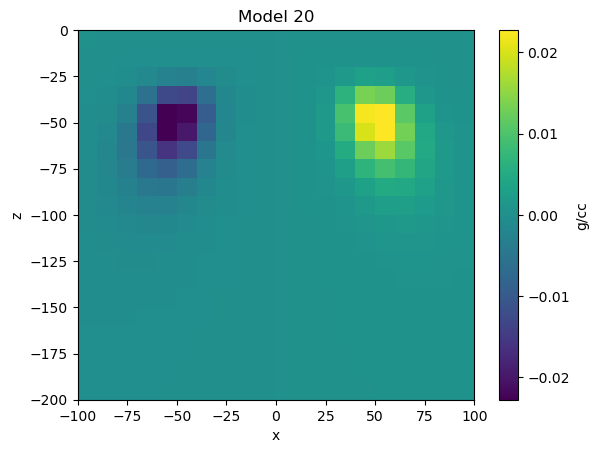

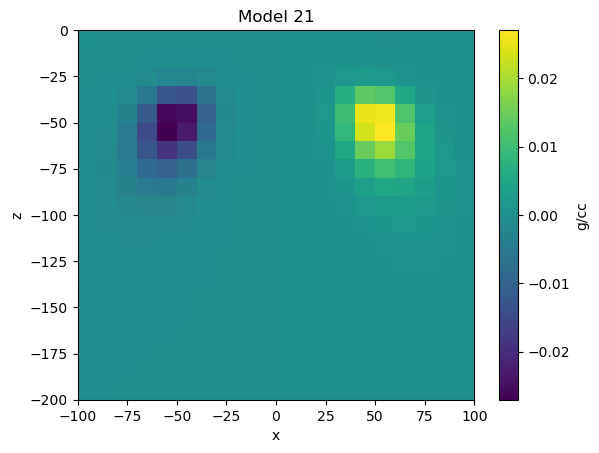

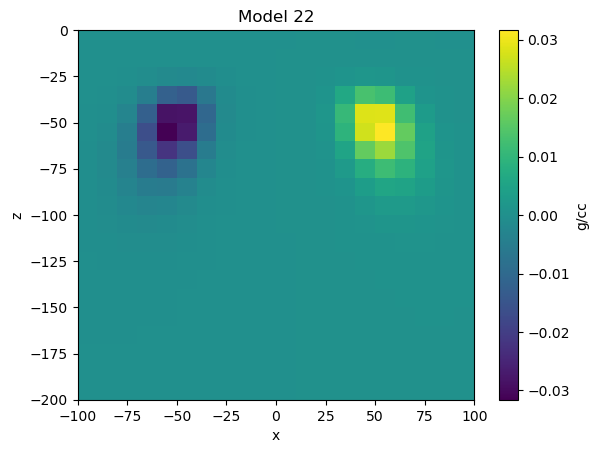

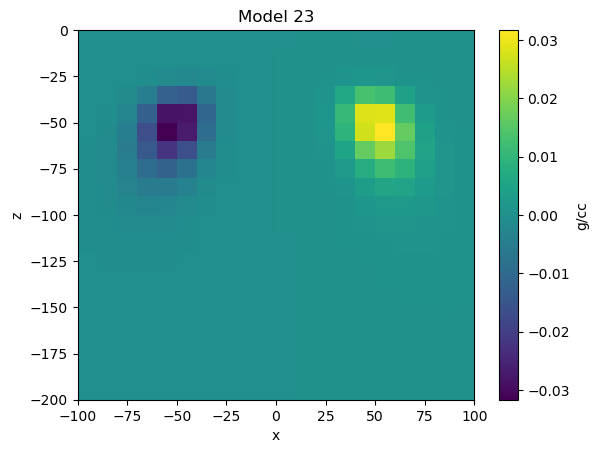

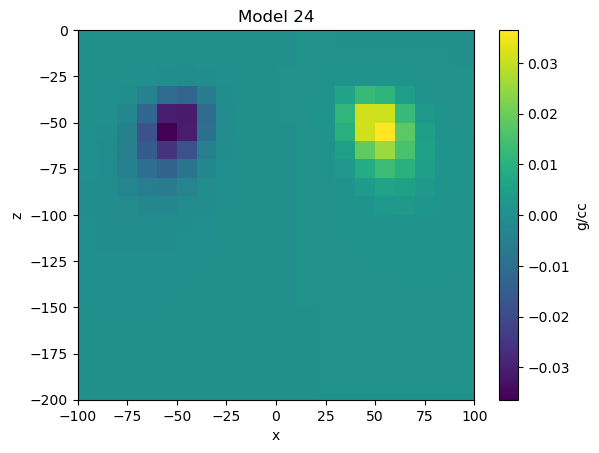

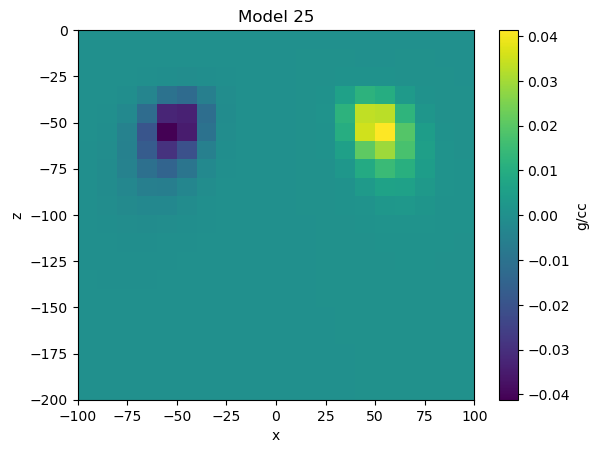

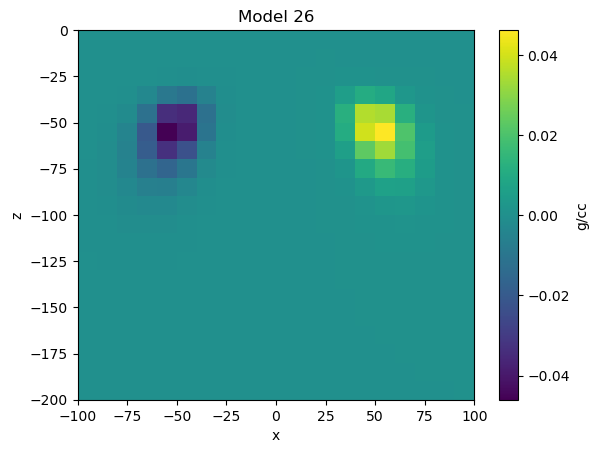

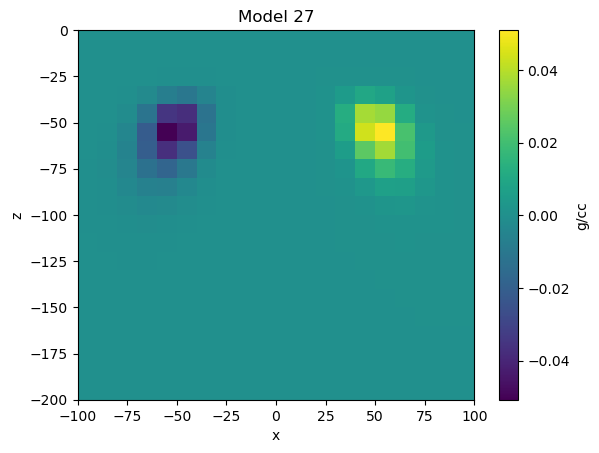

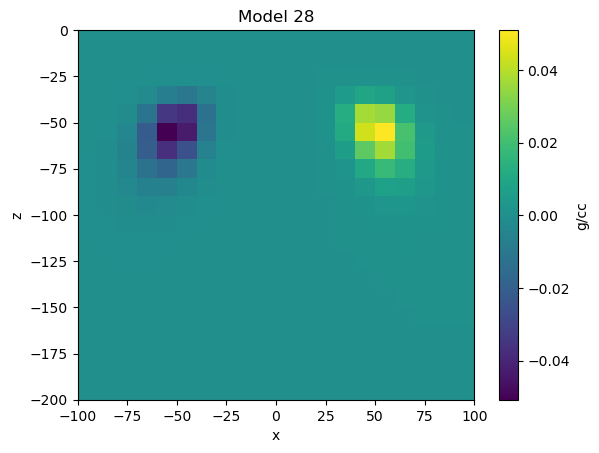

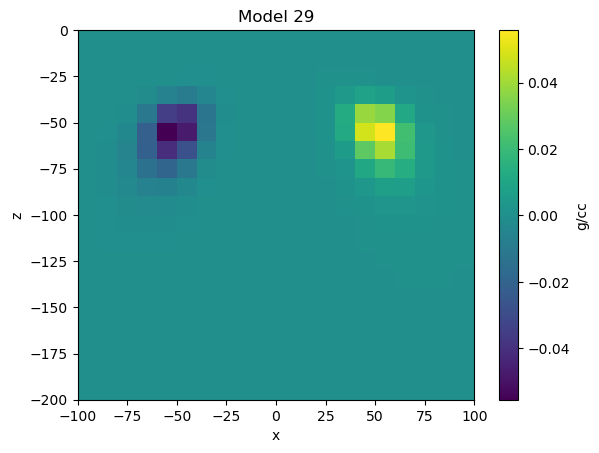

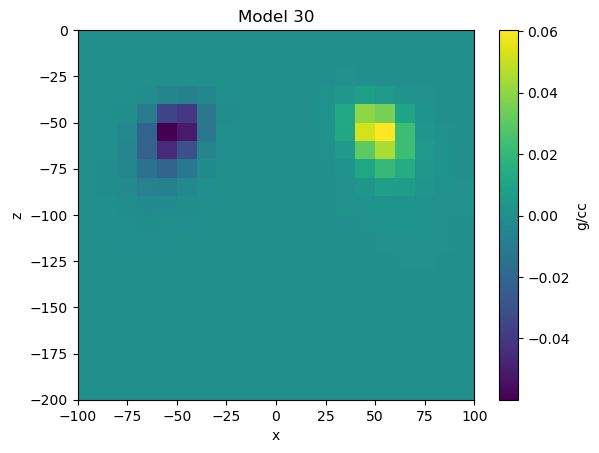

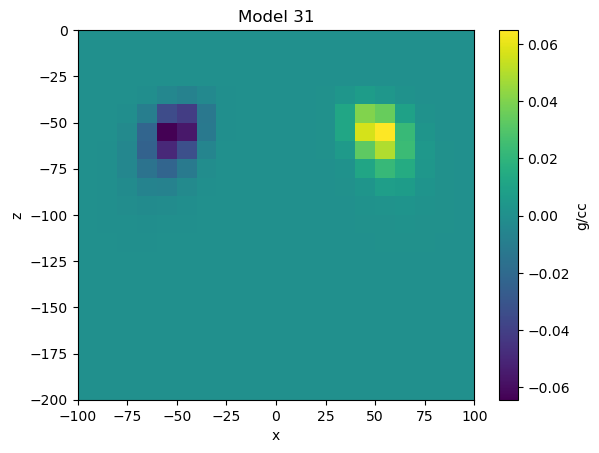

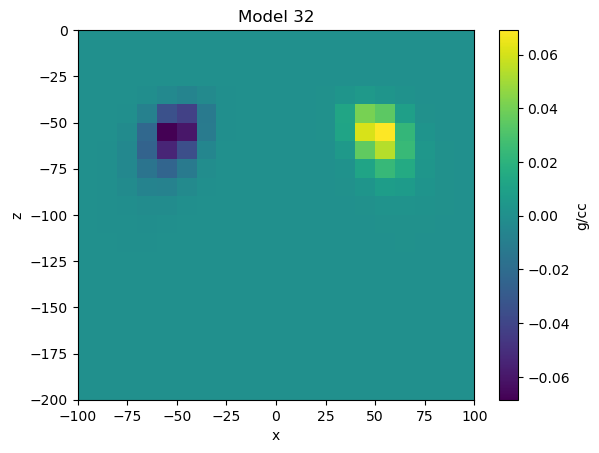

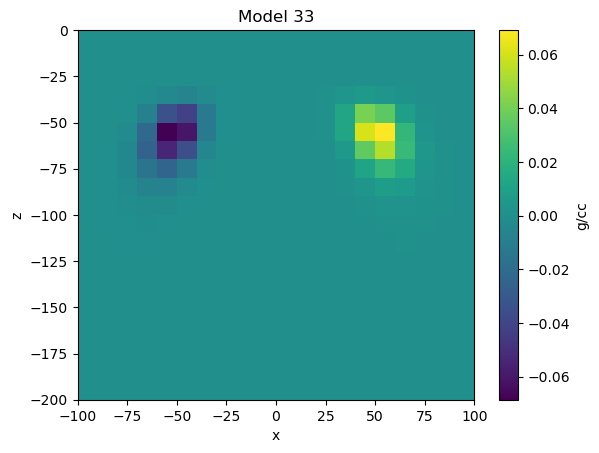

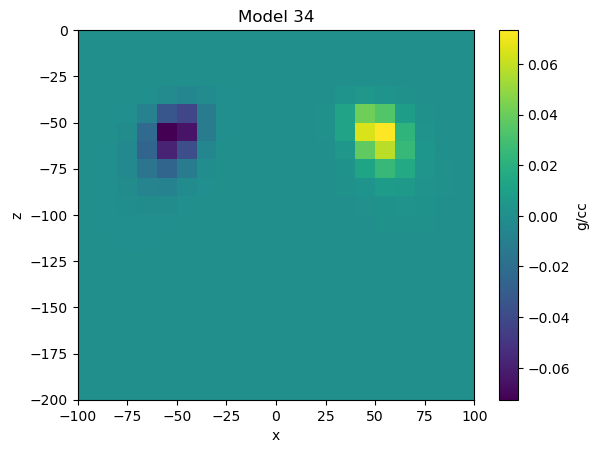

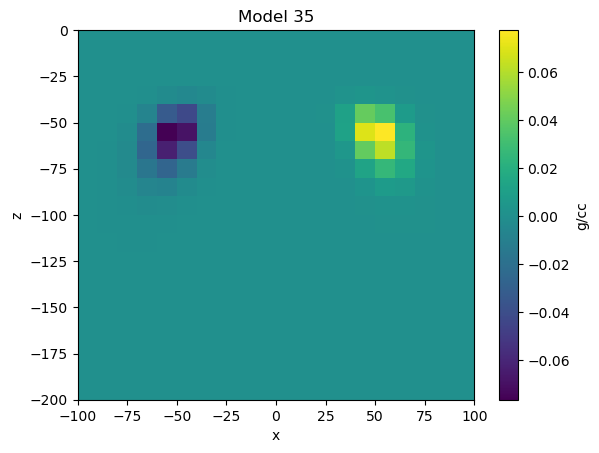

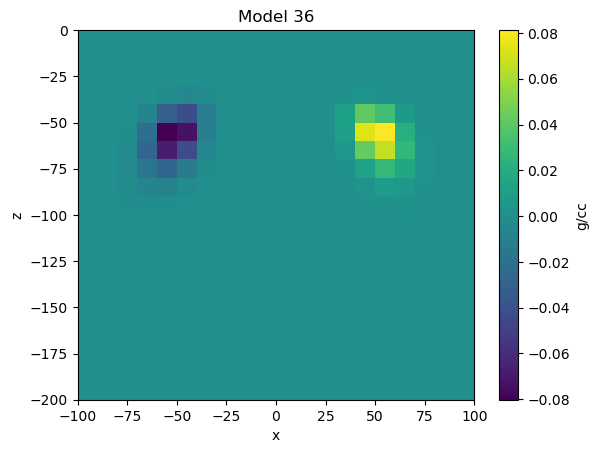

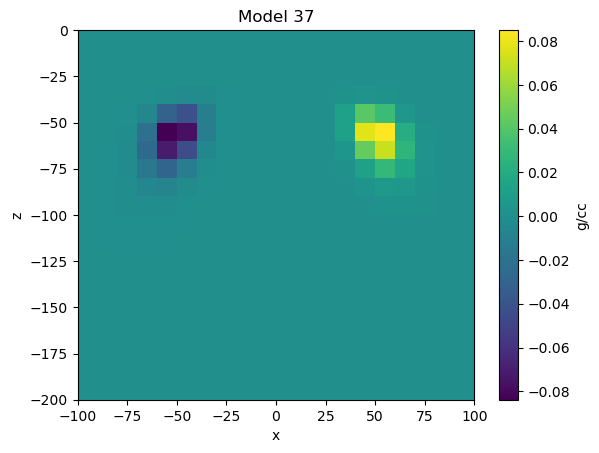

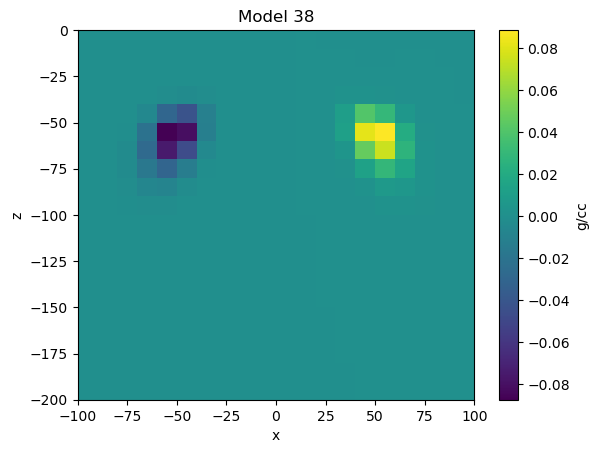

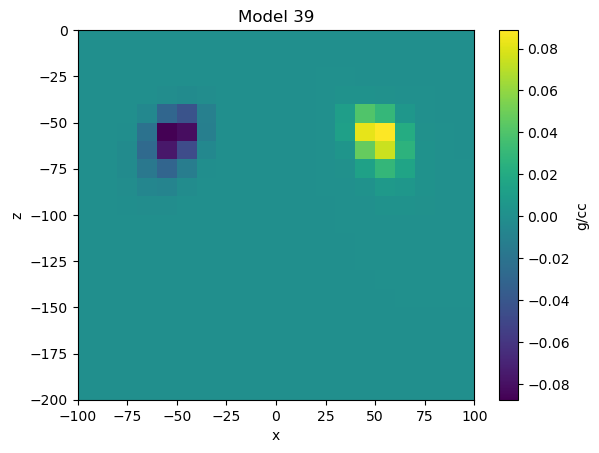

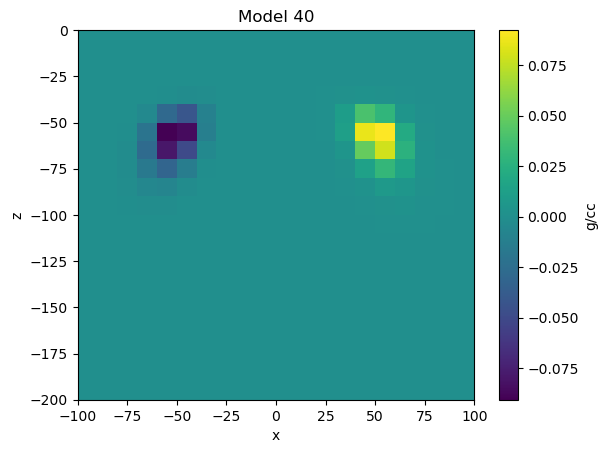

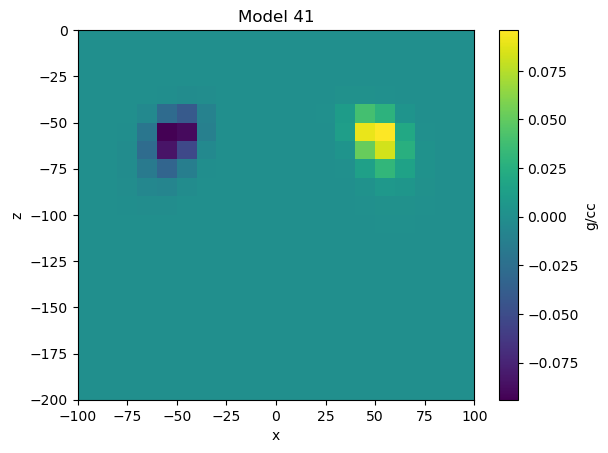

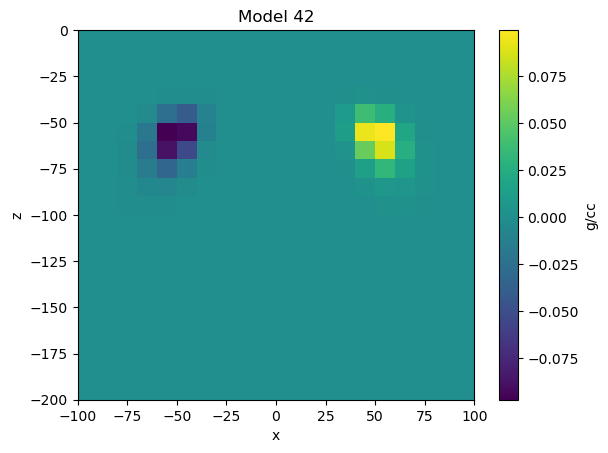

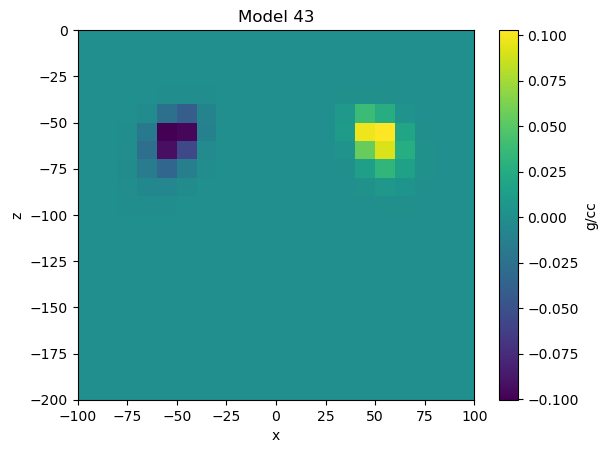

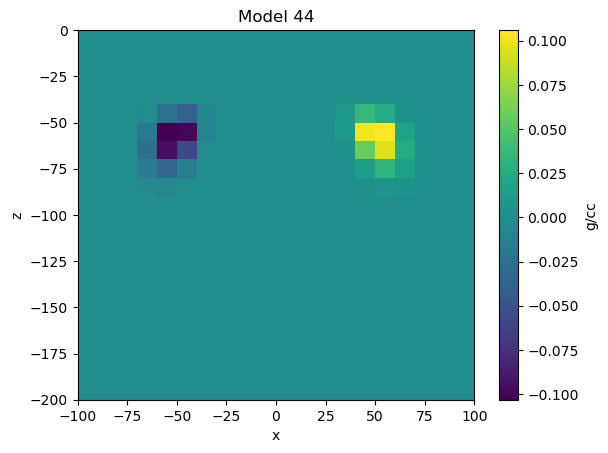

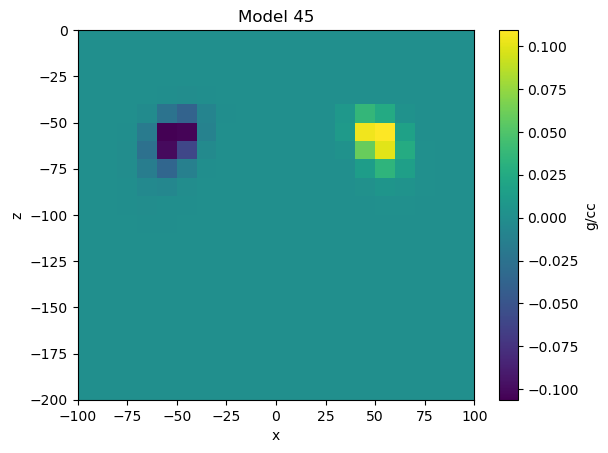

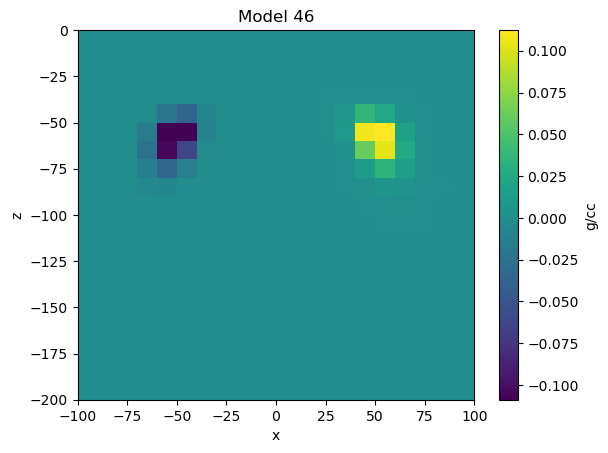

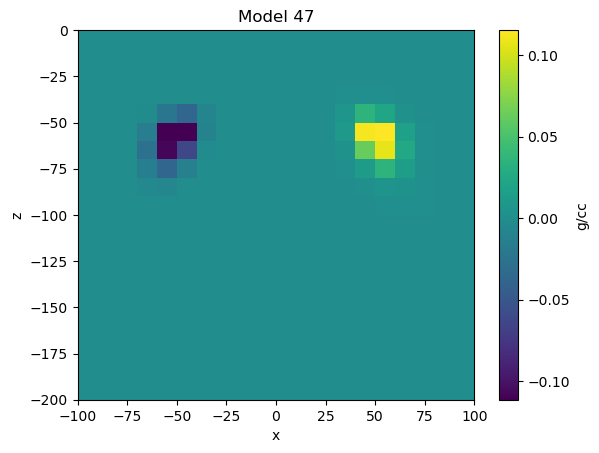

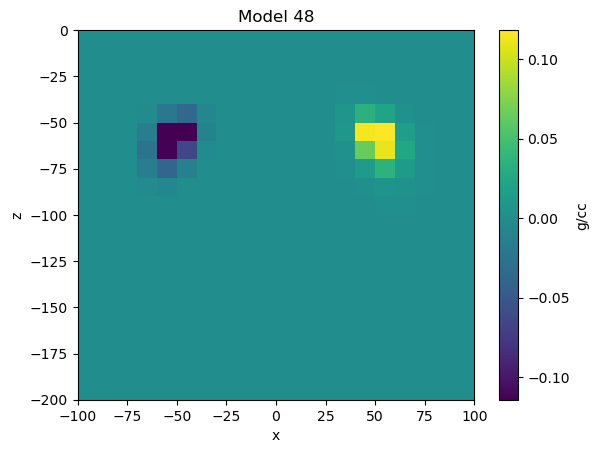

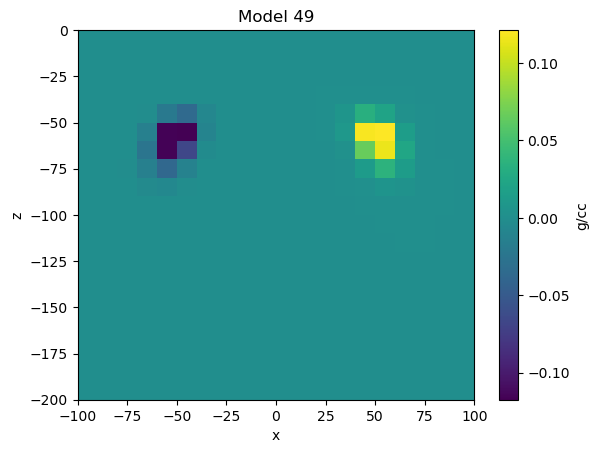

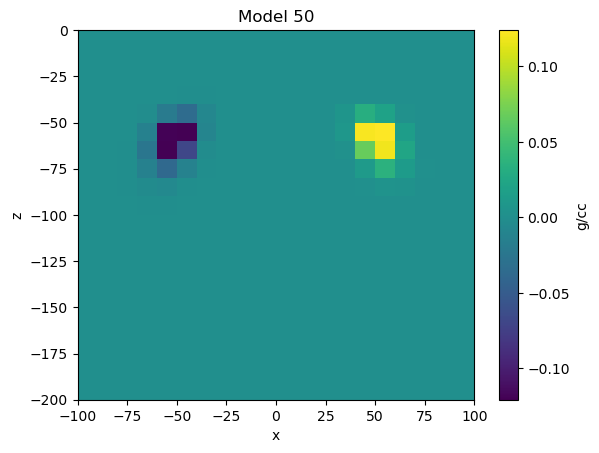

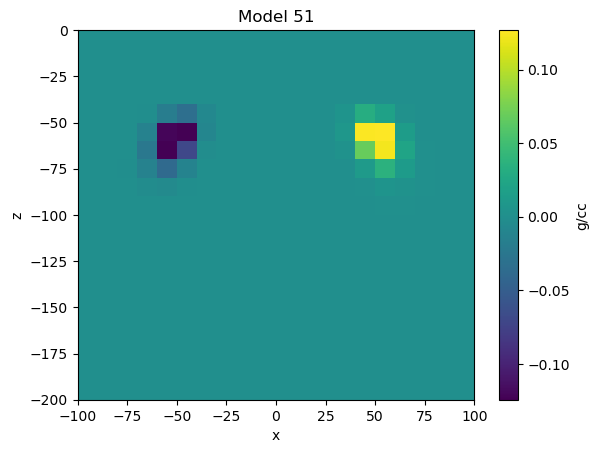

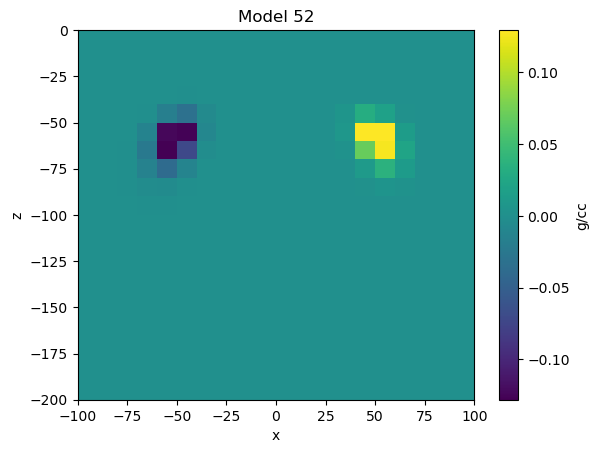

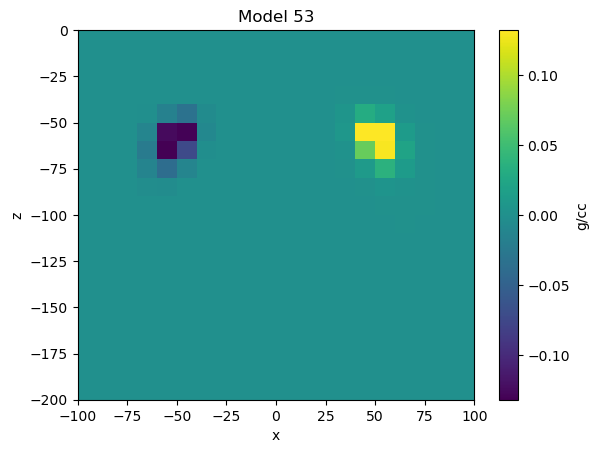

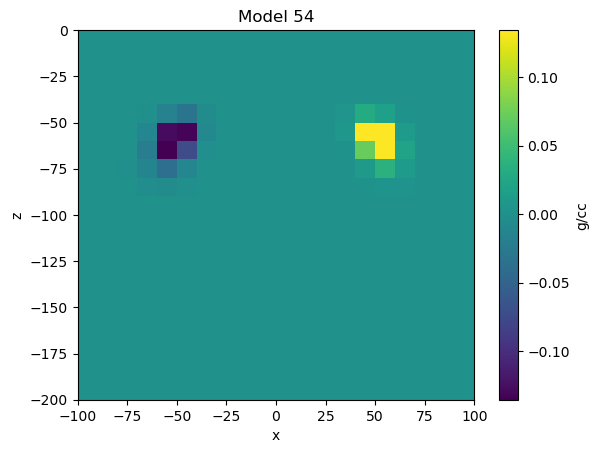

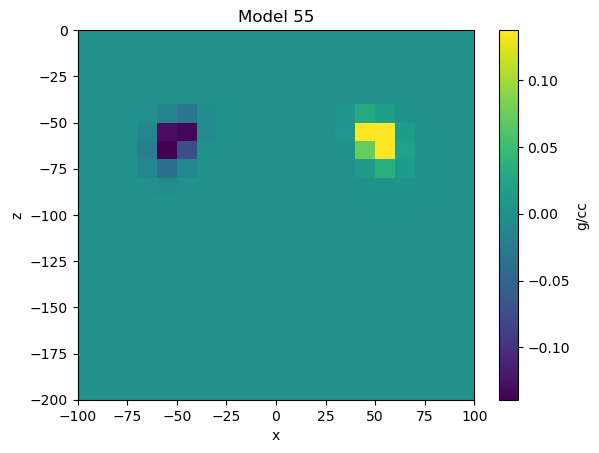

In [26]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()